In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import decomposition
from sklearn import metrics
import itertools

plt.close('all')

In [3]:
############################################################################
#            Loading and visualizing the data
############################################################################

if 1:  # use iris
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
else:  # use digits
    digits = datasets.load_digits()
    X = digits.data
    y = digits.target

    # on ne garde que les 5 premieres classes par simplicite
    X = X[y < 5]
    y = y[y < 5]

# standardize data
X -= X.mean(axis=0)
X /= X.std(axis=0)
X[np.isnan(X)] = 0.


def plot_2d(X, y):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""
    plt.figure()
    symlist = ['o', 's', '*', 'x', 'D', '+', 'p', 'v', 'H', '^']
    collist = ['blue', 'red', 'purple', 'orange', 'salmon', 'black', 'grey',
               'fuchsia']

    labs = np.unique(y)
    idxbyclass = [y == labs[i] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.plot(X[idxbyclass[i], 0], X[idxbyclass[i], 1], '+',
                 color=collist[i % len(collist)], ls='None',
                 marker=symlist[i % len(symlist)])
    plt.ylim([np.min(X[:, 1]), np.max(X[:, 1])])
    plt.xlim([np.min(X[:, 0]), np.max(X[:, 0])])
    plt.show()


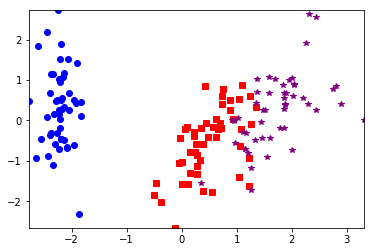

In [4]:
############################################################################
#            Displaying labeled data
############################################################################

# on utilise PCA pour projeter les donnees en 2D
pca = decomposition.PCA(n_components=2)
X_2D = pca.fit_transform(X)
plot_2d(X_2D, y)

In [6]:
############################################################################
#                Stochastic gradient for metric learning
############################################################################


def psd_proj(M):
    """ projection de la matrice M sur le cone des matrices semi-definies
    positives"""
    # calcule des valeurs et vecteurs propres
    eigenval, eigenvec = np.linalg.eigh(M)
    # on trouve les valeurs propres negatives ou tres proches de 0
    ind_pos = eigenval > 1e-10
    # on reconstruit la matrice en ignorant ces dernieres
    M = np.dot(eigenvec[:, ind_pos] * eigenval[ind_pos][np.newaxis, :],
               eigenvec[:, ind_pos].T)
    return M


def hinge_loss_pairs(X, pairs_idx, y_pairs, M):
    """Calcul du hinge loss sur les paires
    """
    diff = X[pairs_idx[:, 0], :] - X[pairs_idx[:, 1], :]
    return np.maximum(0., 1. + y_pairs.T * (np.sum(np.dot(M, diff.T) * diff.T,
                                                   axis=0) - 2.))


def sgd_metric_learning_pairs(X, y, gamma, alpha, n_iter, n_eval, M_ini,
                              random_state=42):
    """Stochastic gradient algorithm for metric learning with pairs

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The targets.
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    alpha : float
        The regularization parameter
    n_iter : int
        The number of iterations
    n_eval : int
        The number of pairs to evaluate the objective function
    M_ini : array, shape (n_features,n_features)
        The initial value of M
    random_state : int
        Random seed to make the algorithm deterministic
    """
    rng = np.random.RandomState(random_state)
    n_samples = X.shape[0]
    # tirer n_eval paires aleatoirement
    pairs_idx = rng.randint(0, n_samples, (n_eval, 2))
    # calcul du label des paires
    y_pairs = 2.0 * (y[pairs_idx[:, 0]] == y[pairs_idx[:, 1]]) - 1.0
    M = M_ini.copy()
    pobj = np.zeros(n_iter)

    if not callable(gamma):
        def gamma_func(t):
            return gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        pobj[t] = np.mean(hinge_loss_pairs(X, pairs_idx, y_pairs, M))
        gradient = np.zeros((n_features, n_features))

        # TODO QUESTION 2
        idx = rng.randint(0, n_samples, 2)
        temp = X[idx[0], :] - X[idx[1], :]
        
        gradient = y[idx]*()
        M -= gamma_func(t) * gradient
        M = psd_proj(M)
    return M, pobj


[ 6 19]


In [ ]:
n_features = X.shape[1]

M_ini = np.eye(n_features)
M, pobj = sgd_metric_learning_pairs(X, y, 0.002, 0.0, 10000, 1000, M_ini)
# M, pobj = sgd_metric_learning_pairs_minibatch(X, y, 0.002, 0.0, 10000, 1000,
#                                               5, 0, M_ini)

plt.figure()
plt.plot(pobj)
plt.xlabel('t')
plt.ylabel('cost')
plt.title('hinge stochastic with pairs')
plt.show()

# on regarde le nombre de valeurs propres egales a 0
e, v = np.linalg.eig(M)
print "Nb de valeurs propres non nulles de M: ", np.sum(e < 1e-12), "/",\
    e.shape[0]


# calcul de la factorisation de cholesky
# on ajoute de tres faibles coefficients sur la diagonale pour eviter
# les erreurs numeriques
L = np.linalg.cholesky(M + 1e-10 * np.eye(n_features))
# on projette lineairement les donnees
X_proj = np.dot(X, L)

# on utilise PCA pour projeter les donnees en 2D
X_proj_2D = pca.fit_transform(X_proj)

# TODO QUESTION 4: projeter X_proj en 2D avec une PCA

# TODO QUESTION 5: tirer paires aleatoires
# calculer les distances et tracer les courbes ROC


#  AIDE POUR LE BONUS DE LA QUESTION 6:

# def combs(a, r):
#     """ compute all r-length combinations of elements in array; a faster
#     than np.array(list(itertools.combinations(a, r)))
#     """
#     a = np.asarray(a)
#     dt = np.dtype([('', a.dtype)] * r)
#     b = np.fromiter(itertools.combinations(a, r), dt)
#     return b.view(a.dtype).reshape(-1, r)
